In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
import sys
import pandas as pd
import seaborn as sns
import xarray as xr

sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
from esn_dts_openloop import ESN, Tikhonov

In [6]:
model = pickle.load(open('SMRAI2_potential_SR.pkl', 'rb'))

#predict on dummy data for By, Bz, Flow speed, density, and tilt

def predict_on_dummy_data(model):
    #dummy data
    By = np.
    Bz = np.random.rand(1000)
    Flow_speed = np.random.rand(1000)
    Density = np.random.rand(1000)
    tilt = np.random.rand(1000)

    #predict
    pred = model.predict(By, Bz, Flow_speed, Density, tilt)
    return pred


In [35]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Load the model
model = pickle.load(open('SMRAI2_potential_SR.pkl', 'rb'))

# Define the function to predict on dummy data
def predict_on_dummy_data(model, By_values, n_values):
    # Generate meshgrid of By and Density values
    By, n = np.meshgrid(By_values, n_values)

    # Flatten the meshgrid arrays
    By_flat = By.flatten()
    n_flat = n.flatten()
        # Fixed values
    Bz = np.zeros_like(n_flat)  # Fixed at 0
    v_sw = np.full_like(n_flat, 400)  # Fixed at 400
    tilt = np.zeros_like(n_flat)  # Fixed at 0

    X_test = np.column_stack((By_flat, Bz, v_sw, n_flat, tilt))

    #predictions_reshaped = predictions.reshape((20, 5))

    # Predict
    pred = model.predict(X_test)
    #pred = pred.reshape(By.shape)

    return pred.shape

# Define values for By and Density
By_values = np.linspace(-10, 10, 10)
Density_values = np.linspace(1, 40, 10)


# Predict using the dummy data
predictions = predict_on_dummy_data(model, By_values, Density_values)

'''
# Plot using contour plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
contour = sns.contourf(Density_values, By_values, predictions, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('Density')
plt.ylabel('By')
plt.title('Prediction Contour Plot')
plt.show()'''

predictions


(100, 2400)

In [126]:
# Define the function to predict on dummy data
def predict_on_dummy_data(model, Bz_values, n_values):
    # Initialize an array to store predictions
    all_predictions = []

    # Loop through all combinations of By and density values
    for Bz in Bz_values:
        for density in n_values:
            # Generate the input data for prediction
            By = 0  #nT
            v_sw = 400  #m/s
            tilt = 0  #degrees
            X_test = np.array([[By, Bz, v_sw, density, tilt]])

            # Predict
            pred = model.predict(X_test)

            # Store the prediction
            all_predictions.append(pred)

    # Convert the list of predictions to a numpy array
    all_predictions = np.array(all_predictions)

    # Reshape the predictions array to match the shape of Bz_values and Density_values
    all_predictions = all_predictions.reshape((len(Bz_values), len(n_values), -1))

    return all_predictions

# Define values for By and Density
Bz_values = np.arange(-10, 0, 1)
n_values = np.arange(2, 41, 2)

# Predict using the dummy data
predictions = predict_on_dummy_data(model, Bz_values, n_values)

In [152]:
np.linspace(0,360,80)

array([  0.        ,   4.55696203,   9.11392405,  13.67088608,
        18.2278481 ,  22.78481013,  27.34177215,  31.89873418,
        36.4556962 ,  41.01265823,  45.56962025,  50.12658228,
        54.6835443 ,  59.24050633,  63.79746835,  68.35443038,
        72.91139241,  77.46835443,  82.02531646,  86.58227848,
        91.13924051,  95.69620253, 100.25316456, 104.81012658,
       109.36708861, 113.92405063, 118.48101266, 123.03797468,
       127.59493671, 132.15189873, 136.70886076, 141.26582278,
       145.82278481, 150.37974684, 154.93670886, 159.49367089,
       164.05063291, 168.60759494, 173.16455696, 177.72151899,
       182.27848101, 186.83544304, 191.39240506, 195.94936709,
       200.50632911, 205.06329114, 209.62025316, 214.17721519,
       218.73417722, 223.29113924, 227.84810127, 232.40506329,
       236.96202532, 241.51898734, 246.07594937, 250.63291139,
       255.18987342, 259.74683544, 264.30379747, 268.86075949,
       273.41772152, 277.97468354, 282.53164557, 287.08

In [176]:
pred_4d = predictions.reshape(10,20,30,80)
#take first 40 from 4th dimension
pred_nightside = pred_4d[:,:,:,20:60]
#pred_dayside = pred_4d[:,:,:,40:]


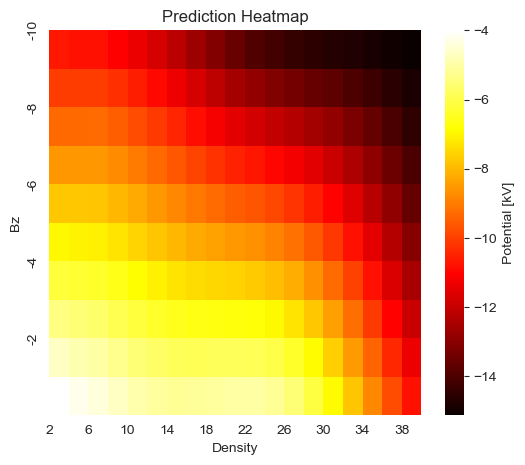

In [177]:
mean_pred = pred_nightside.mean(axis=3)
mean_pred = mean_pred.mean(axis=2)
mean_pred = mean_pred[:,1:] #first column is buggy

#plot as contour plot
plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
#sns.heatmap(mean_pred, cmap='coolwarm', center=0, annot=False, fmt=".0f", cbar_kws={'label': 'Potential [Kv]'})
sns.heatmap(mean_pred, cmap='hot', annot=False, fmt=".0f", cbar_kws={'label': 'Potential [kV]'})
plt.colorbar(contour)
plt.xticks(ticks=np.arange(0, len(n_values), 2), labels=n_values[::2])
plt.xlabel('Density')
plt.yticks(ticks=np.arange(0, len(Bz_values), 2), labels=Bz_values[::2])
plt.ylabel('Bz')

plt.title('Prediction Heatmap')
#change colourbar label
plt.show()


In [139]:
predictions.shape

(10, 20, 2400)

In [148]:
theta = np.linspace(0, 360, 24) #shift by 90 degrees
theta_rad = np.deg2rad(theta) #convert to radians
mlt = theta_rad/np.pi*12 #convert to MLT
mlt

array([ 0.        ,  1.04347826,  2.08695652,  3.13043478,  4.17391304,
        5.2173913 ,  6.26086957,  7.30434783,  8.34782609,  9.39130435,
       10.43478261, 11.47826087, 12.52173913, 13.56521739, 14.60869565,
       15.65217391, 16.69565217, 17.73913043, 18.7826087 , 19.82608696,
       20.86956522, 21.91304348, 22.95652174, 24.        ])

TypeError: Input z must be 2D, not 3D

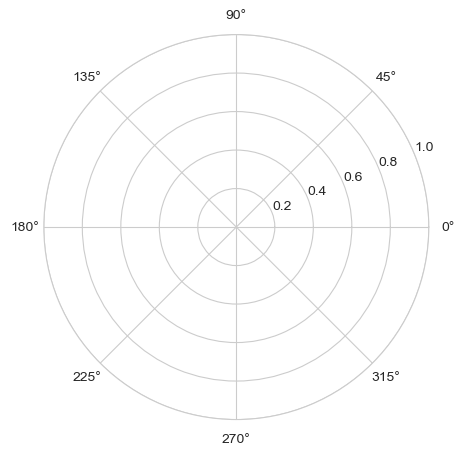

In [137]:

theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5, 5))
radar = ax.contourf(theta_rad, r, predictions, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')

'''
# Plot true values
c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')'''
